In [64]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
import scipy.interpolate as interp

In [65]:
# Resistor values (Ohm)
R_1 = 100
R_2 = 20E3
R_3 = 47E3
R_4 = 200
R_5 = 2E3

# Capacitor values (F)
C_1 = 680E-12
C_2 = 0.22E-6
C_3 = 1E-9

def Z_c(C, f):
    """
    Capacitor impedance
    """
    
    return 1 / (2 * np.pi * f * C * complex(0, 1))


def VDG(Z_1, Z_2):
    """
    Gain factor for voltage divider Op-amp circuit
    """

    return (Z_1 + Z_2) / Z_1


def VDF(Z_1, Z_2):
    """
    Voltage divider circuit gain factor
    """

    return Z_1 / (Z_2 + Z_1)


def c_amp(f):
    """
    Final complex amplification factor for entire circuit
    """
    
    return VDG(R_1, 1/(1/R_2 + 1/Z_c(C_1, f))) * VDF(R_3, Z_c(C_2, f)) * VDG(R_4, 1/(1/R_5 + 1/Z_c(C_3, f)))


def amplification(c_amp):
    """
    Converts complex amplification factor to real amplification factor
    """
    
    return np.sqrt(c_amp * c_amp.conjugate()).real

def phase(c_amp):
    """
    Converts complex amplification factor to phase shift
    """

    # c_amp lies in Q1 of complex plane
    if c_amp.real >= 0 and c_amp.imag >= 0:
        return np.arctan(c_amp.imag / c_amp.real)
    
    # c_amp lies in Q2 of complex plane
    elif c_amp.real < 0 and c_amp.imag >= 0:
        return -np.pi + np.arctan(c_amp.imag / c_amp.real)
   
    # c_amp lies in Q3 of complex plane
    elif c_amp.real < 0 and c_amp.imag < 0:
        return np.arctan(c_amp.imag / c_amp.real) - np.pi

    # c_amp lies in Q4 of complex plane
    else:
        return np.arctan(c_amp.imag / c_amp.real)

In [66]:
V_1 = 50E-3
u_V_in = 1E-3
cR_1 = 120.26E3
cf_arr = np.array([])

for i in range(21):
    f = 10 ** (i * 0.25)
    ecR_2 = cR_1 / (amplification(c_amp(f)) / 2 - 1)
    cf_arr = np.append(cf_arr, round(f))
    # print(round(ecR_2.real), round(f))


In [67]:
V_1 = 50E-3
u_V_in = 1E-3
cR_1 = 120.26E3
cf_arr = np.array([])

for i in range(21):
    f = 10 ** (i * 0.25)
    ecR_2 = cR_1 / (amplification(c_amp(f)) / 2 - 1)
    cf_arr = np.append(cf_arr, round(f))

def v_into_amp(V_in, R_1, R_2):
    return V_in * R_2 / (R_1 + R_2)


cR_2 = np.array([982.4, 982.4, 391.017, 391.017, 200.64, 150.241, 150.241, 120.543, 120.543,
                 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543,
                 120.543, 325.049, 392.225, 980.54])
obs_V_out = np.array([0.0512/2, 0.117/2, 0.0888/2, 0.227/2, 0.188/2, 0.206/2, 0.249/2, 0.217/2, 
                      0.228/2, 0.224/2, 0.223/2, 0.22/2, 0.22/2, 0.218/2, 0.211/2, 0.191/2,
                      0.153/2, 0.101/2, 0.158/2, 0.091/2, 0.0925/2])

V_in = v_into_amp(V_1, cR_1, cR_2)

obs_G = obs_V_out / V_in
obs_G_err = obs_G*np.sqrt(((2E-3 + obs_V_out * 0.01)/obs_V_out)**2 + ((v_into_amp(2E-3, cR_1, cR_2) + V_in * 0.01)/V_in)**2)


def fourier_series(x, a0, an, bn, T):
    series = a0  # Start with the constant term
    for n in range(1, len(an) + 1):
        series += an[n - 1] * np.cos(2 * np.pi * n * np.log10(x) / T) + bn[n - 1] * np.sin(2 * np.pi * n * np.log10(x) / T)
    return series

T = 5

fourier_coeffs = np.fft.fft(obs_G) / len(cf_arr)

a0 = fourier_coeffs[0].real
an = 2 * fourier_coeffs[1:len(fourier_coeffs) // 2].real
bn = -2 * fourier_coeffs[1:len(fourier_coeffs) // 2].imag

def mod_fourier_series(x, a, b, c, d, e, f, g, h, j):
    return fourier_series(x, a0, an, bn, T) + a + b*(x+c) + d*(x+e)**2 + f*(x+g)**3 + h*(x+j)**4


params, cov = curve_fit(mod_fourier_series, cf_arr, obs_G)

def piece_func(x):
    y = np.array([])
    
    for i in x:
        if i < 10:
            y = np.append(y, fourier_series(i, a0, an, bn, T) - 11)
        elif i < 56:
            y = np.append(y, mod_fourier_series(i, *params))
        elif i < 70:
            y = np.append(y, mod_fourier_series(i, *params) * 2.3 - 2840)
        elif i < 1000:
            y = np.append(y, fourier_series(i, a0, an, bn, T))
        elif i < 2500:
            y = np.append(y, amplification(c_amp(i)))
        elif i < 4000:
            y = np.append(y, amplification(c_amp(i)) * 1.2 - 440)
        elif i < 20000:
            y = np.append(y, mod_fourier_series(i, *params) + 10) 
        else:
            y = np.append(y, amplification(c_amp(i))*0.9 - 30)
    return y

chi_squared = np.sum(((obs_G - piece_func(cf_arr)) / obs_G_err) ** 2)
red_chi_squared = chi_squared / (1 + len(an) + len(bn))

print(red_chi_squared)

0.5314218130742651


Text(0.5, 0, 'Frequency (Hz)')

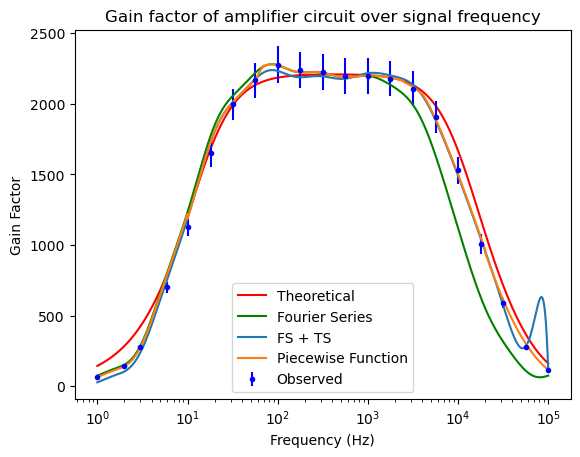

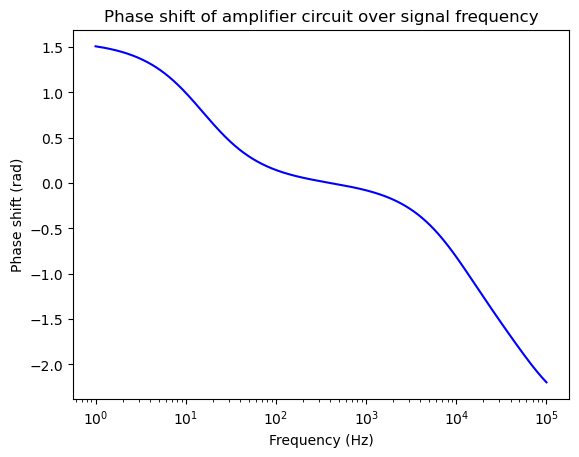

In [68]:
f_arr = np.logspace(0, 5, 5000)

amp_arr = []
phase_arr = []

for f in f_arr:
    amp_arr.append(amplification(c_amp(f)))
    phase_arr.append(phase(c_amp(f)))

fig0 = plt.figure(0)
ax0 = fig0.add_subplot()
ax0.set_xscale('log')
ax0.plot(f_arr, amp_arr, 'r', label='Theoretical')
ax0.set_title('Gain factor of amplifier circuit over signal frequency')
ax0.set_ylabel('Gain Factor')
ax0.set_xlabel('Frequency (Hz)')
ax0.errorbar(cf_arr, obs_G, yerr=obs_G_err, fmt='b.', label='Observed')
ax0.plot(f_arr, fourier_series(f_arr, a0, an, bn, T), 'g', label='Fourier Series')
ax0.plot(f_arr, mod_fourier_series(f_arr, *params), label='FS + TS')
ax0.plot(f_arr, piece_func(f_arr), label='Piecewise Function')
ax0.legend()

fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.set_xscale('log')
ax1.plot(f_arr, phase_arr, 'b')
ax1.set_title('Phase shift of amplifier circuit over signal frequency')
ax1.set_ylabel('Phase shift (rad)')
ax1.set_xlabel('Frequency (Hz)')